In [37]:
import tensorflow
import keras

print('程式執行環境:')
print('tensorflow', tensorflow.__version__)
print('keras',keras.__version__)

程式執行環境:
tensorflow 2.8.0
keras 2.8.0


### Generator setting

In [45]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

DATASET_PATH  = 'picture' # 資料路徑
IMAGE_SIZE = (150, 150) # 影像大小
NUM_CLASSES = 2 # 影像類別數
NUM_EPOCHS, BATCH_SIZE = 20, 32

# 模型參數檔
WEIGHTS_FINAL = 'model-resnet50-final.h5'

### 設定 data augmentation 參數
train_datagen = ImageDataGenerator(rescale = 1./255, # 將像素從 0~255 縮放到 0~1 之間
                                   rotation_range=40, # 於[0, 40]之間進行照片旋轉
                                   width_shift_range=0.2, # 水平平移[0, 0.2]圖片尺寸
                                   height_shift_range=0.2, # 垂直平移
                                   shear_range=0.2, # 錯切變換(效果類似將矩形轉平行四邊形)
                                   zoom_range=0.2, # 讓圖片在某個方向(長、寬)進行放大縮小
                                   channel_shift_range=10, # 對顏色通道的數值進行偏移，數值越深，顏色越深
                                   horizontal_flip=True, # 隨機對圖片進行水平翻轉
                                   fill_mode='nearest') # 對圖片進行填充

### 設定 generator
train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='binary',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 145 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


### Model Setting

In [39]:
from keras.applications import vgg16
from keras import layers, models

### 引入VGG16模型
conv_base = vgg16.VGG16(weights='imagenet', # 使用imageNet預先訓練的資料
                 include_top=False, # 不包含全連接層
                 input_shape=(150, 150, 3))

### 加入全連接層
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

### 設定模型優化器
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=2e-5),
             metrics=['acc'])

c:\Users\mljgs\anaconda3\envs\Jerry\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Model training

In [42]:
### 訓練模型
training_data_size = 145
testing_data_size = 35
train_epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch = int(training_data_size/BATCH_SIZE), # 要取得多少批次量
    epochs = train_epochs,
    validation_data = validation_generator,
    validation_steps = int(testing_data_size/BATCH_SIZE)
)

Epoch 1/100
4/4 [==============================] - 20s 5s/step - loss: 0.0655 - acc: 0.9766 - val_loss: 0.1643 - val_acc: 0.9688
Epoch 2/100
4/4 [==============================] - 17s 4s/step - loss: 0.1346 - acc: 0.9823 - val_loss: 0.0464 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 17s 4s/step - loss: 0.0802 - acc: 0.9646 - val_loss: 0.1120 - val_acc: 0.9688
Epoch 4/100
4/4 [==============================] - 19s 5s/step - loss: 0.0383 - acc: 1.0000 - val_loss: 0.1407 - val_acc: 0.9688
Epoch 5/100
4/4 [==============================] - 17s 4s/step - loss: 0.0717 - acc: 0.9823 - val_loss: 0.0947 - val_acc: 0.9688
Epoch 6/100
4/4 [==============================] - 19s 5s/step - loss: 0.0671 - acc: 0.9688 - val_loss: 0.1404 - val_acc: 0.9688
Epoch 7/100
4/4 [==============================] - 17s 4s/step - loss: 0.1309 - acc: 0.9292 - val_loss: 0.2018 - val_acc: 0.9688
Epoch 8/100
4/4 [==============================] - 19s 5s/step - loss: 0.0568 - acc: 0.9844 - val

### Model Evaluation

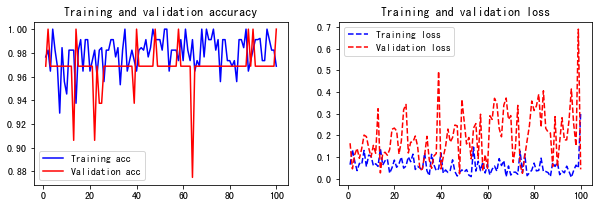

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,3))
epochs = range(1, len(acc) + 1)

plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

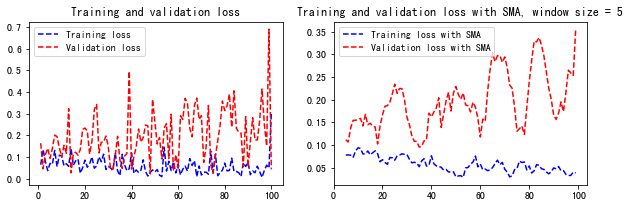

In [96]:
import numpy as np

### 用SMA(簡單移動平均)處理loss value
win_size = 5
loss_SMA = [np.average(loss[ind-win_size:ind]) for ind in range(win_size, len(loss))]
val_loss_SMA = [np.average(val_loss[ind-win_size:ind]) for ind in range(win_size, len(val_loss))]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)
plt.plot(range(win_size, win_size + len(loss_SMA)), loss_SMA, 'b--', label='Training loss with SMA')
plt.plot(range(win_size, win_size + len(val_loss_SMA)), val_loss_SMA, 'r--', label='Validation loss with SMA')
plt.xticks(range(0, win_size + len(loss_SMA) + 1, 20))
plt.title('Training and validation loss with SMA, window size = ' + str(win_size))
plt.legend()

plt.show()

In [102]:
### Retrain model

### 訓練模型
training_data_size = 145
testing_data_size = 35
train_epochs = 17

history = model.fit(
    train_generator,
    steps_per_epoch = int(training_data_size/BATCH_SIZE), # 要取得多少批次量
    epochs = train_epochs,
    validation_data = validation_generator,
    validation_steps = int(testing_data_size/BATCH_SIZE)
)

Epoch 1/17
4/4 [==============================] - 21s 5s/step - loss: 0.0197 - acc: 0.9922 - val_loss: 0.1311 - val_acc: 0.9688
Epoch 2/17
4/4 [==============================] - 19s 5s/step - loss: 0.0194 - acc: 0.9823 - val_loss: 0.2448 - val_acc: 0.9688
Epoch 3/17
4/4 [==============================] - 21s 5s/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 0.9688
Epoch 4/17
4/4 [==============================] - 20s 5s/step - loss: 0.0272 - acc: 0.9844 - val_loss: 0.0675 - val_acc: 0.9688
Epoch 5/17
4/4 [==============================] - 18s 4s/step - loss: 0.1388 - acc: 0.9558 - val_loss: 0.1279 - val_acc: 0.9688
Epoch 6/17
4/4 [==============================] - 19s 5s/step - loss: 0.0197 - acc: 1.0000 - val_loss: 0.1193 - val_acc: 0.9688
Epoch 7/17
4/4 [==============================] - 19s 5s/step - loss: 0.0738 - acc: 0.9735 - val_loss: 0.1716 - val_acc: 0.9688
Epoch 8/17
4/4 [==============================] - 19s 5s/step - loss: 0.0392 - acc: 0.9823 - val_loss: 0

In [105]:
from keras.preprocessing import image

### Testing labe=1 picture
predicted_classes = []
ans_ture = 0
for name in os.listdir('picture/test/1'):
    img = image.load_img('picture/test/1/' + name , target_size=(150,150))
    img = image.img_to_array(img)
    img = img.reshape((1,) + img.shape)
    ans_ture = ans_ture + 1 if int(model.predict(img)[0][0]) == 1 else ans_ture
    predicted_classes.append(int(model.predict(img)[0][0]))
    
# print(predicted_classes)
print('Accuracy for label=1 :', ans_ture/len(predicted_classes))

### Testing label=0 picture
predicted_classes = []
ans_ture = 0
for name in os.listdir('picture/test/0'):
    img = image.load_img('picture/test/0/' + name , target_size=(150,150))
    img = image.img_to_array(img)
    img = img.reshape((1,) + img.shape)
    ans_ture = ans_ture + 1 if int(model.predict(img)[0][0]) == 0 else ans_ture
    predicted_classes.append(int(model.predict(img)[0][0]))

# print(predicted_classes)
print('Accuracy for label=0 :', ans_ture/len(predicted_classes))

Accuracy for label=1 : 1.0
Accuracy for label=0 : 0.4


In [106]:
# 儲存模型(label=0準確度不高，可能因為訓練資料不平衡)
model.save('mumu_is_here_or_not_test.h5')